In [100]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from config import ARXIV_DATASET
from itertools import combinations
from wordcloud import WordCloud


MAX_ARTICLES = 20000

## Data exploration

In [3]:
def clean_text(text :str) -> str:
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [12]:
with open(ARXIV_DATASET, 'rb') as f:
    for line in f:
        paper_1 = json.loads(line)
        break

In [13]:
print(paper_1)

{'id': '0704.0001', 'submitter': 'Pavel Nadolsky', 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan", 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'comments': '37 pages, 15 figures; published version', 'journal-ref': 'Phys.Rev.D76:013009,2007', 'doi': '10.1103/PhysRevD.76.013009', 'report-no': 'ANL-HEP-PR-07-12', 'categories': 'hep-ph', 'license': None, 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab

In [14]:
print(paper_1.keys())

dict_keys(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'])


In [69]:
titles = []
abstracts = []
categories = []
authors = []
years = []
journals = []


with open(ARXIV_DATASET, 'rb') as f:
    for idx, line in enumerate(f):
        temp = json.loads(line)
        titles.append(clean_text(temp['title']))
        abstracts.append(clean_text(temp['abstract']))
        categories.append(temp['categories'])
        authors.append(temp['authors_parsed'])
        years.append(temp['update_date'][:4])
        journals.append(temp['journal-ref'])
        if idx + 1 == MAX_ARTICLES:
            break

print(f"Loaded {len(titles)} papers")

Loaded 20000 papers


In [71]:
df = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'categories': categories,
    'authors': authors,
    'year': years,
    'journal': journals
})

df.head()

,title,abstract,categories,authors,year,journal
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbati...,hep-ph,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",2008,"Phys.Rev.D76:013009,2007"
1,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2008,None
2,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is describe...,physics.gen-ph,"[[Pan, Hongjun, ]]",2008,None
3,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle n...,math.CO,"[[Callan, David, ]]",2007,None
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\Lam...,math.CA math.FA,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2013,"Illinois J. Math. 52 (2008) no.2, 681-689"


## Data Analysis

### Abstract

In [38]:
df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))

print(f"Average abstract length: {df['abstract_length'].mean()}")
print(f"Minimum abstract length: {df['abstract_length'].min()}")
print(f"Maximum abstract length: {df['abstract_length'].max()}")

Average abstract length: 121.4213
Minimum abstract length: 2
Maximum abstract length: 342


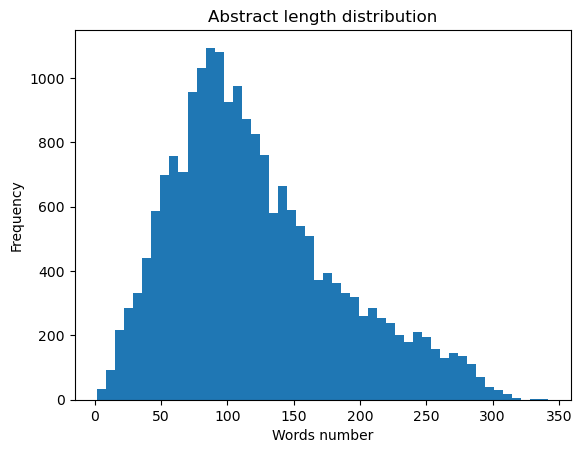

In [39]:
plt.hist(df['abstract_length'], bins=50)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('Abstract length distribution')
plt.show()


### Categories

In [40]:
all_cats = []
for cat in df['categories']:
    all_cats.extend(cat.split())

print(f"Total categories: {len(all_cats)}")

Total categories: 30074


In [41]:
c = Counter(all_cats)
top_cat = c.most_common(20)

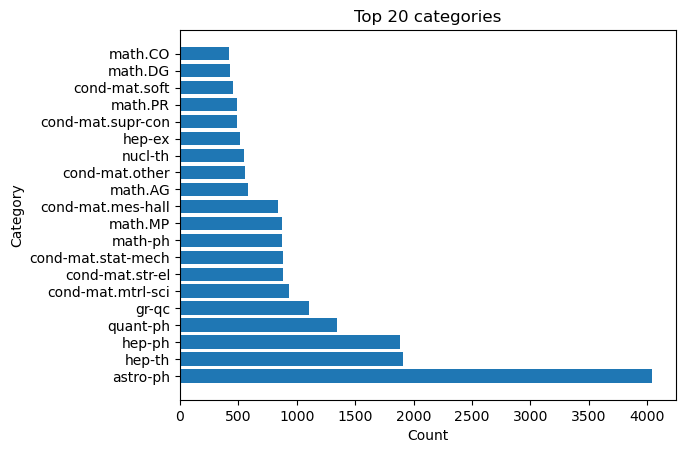

In [42]:
cat_df = pd.DataFrame(top_cat, columns=['category', 'count'])
plt.barh(cat_df['category'], cat_df['count'])
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Top 20 categories')
plt.show()

### Authors

In [43]:
df['authors_count'] = df['authors'].apply(lambda x: len(x))
print(f"Average authors count: {df['authors_count'].mean()}")
print(f"Minimum authors count: {df['authors_count'].min()}")
print(f"Maximum authors count: {df['authors_count'].max()}")

Average authors count: 3.13895
Minimum authors count: 1
Maximum authors count: 115


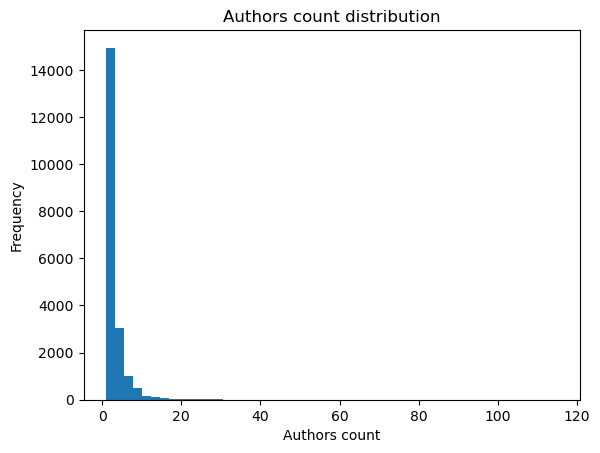

In [44]:
plt.hist(df['authors_count'], bins=50)
plt.xlabel('Authors count')
plt.ylabel('Frequency')
plt.title('Authors count distribution')
plt.show()

In [61]:
all_authors = []
df['authors_concat'] = df['authors'].apply(lambda x : [" ".join(y[::-1]) for y in x])
for authors in df['authors_concat']:
    all_authors.extend(authors)

print(f"Total authors: {len(all_authors)}")

Total authors: 62779


In [62]:
c = Counter(all_authors)
top_authors = c.most_common(20)

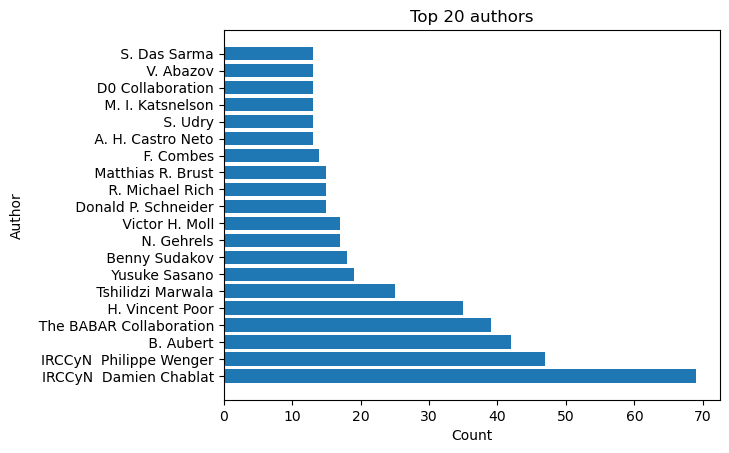

In [63]:
authors_df = pd.DataFrame(top_authors, columns=['author', 'count'])
plt.barh(authors_df['author'], authors_df['count'])
plt.xlabel('Count')
plt.ylabel('Author')
plt.title('Top 20 authors')
plt.show()

### Publications by year

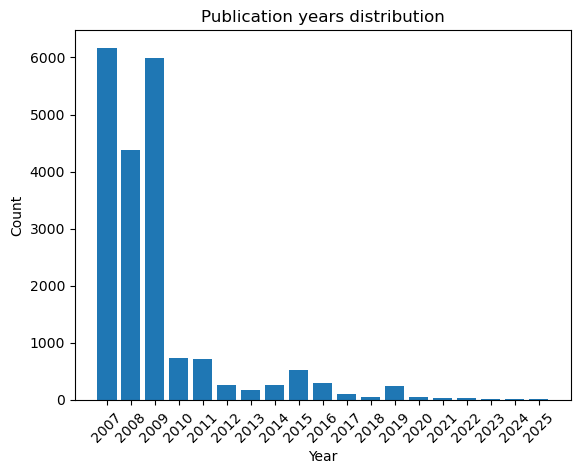

In [80]:
years_count = df['year'].value_counts().sort_index()

plt.bar(years_count.index, years_count.values)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Publication years distribution')
plt.show()

### Category Heatmap

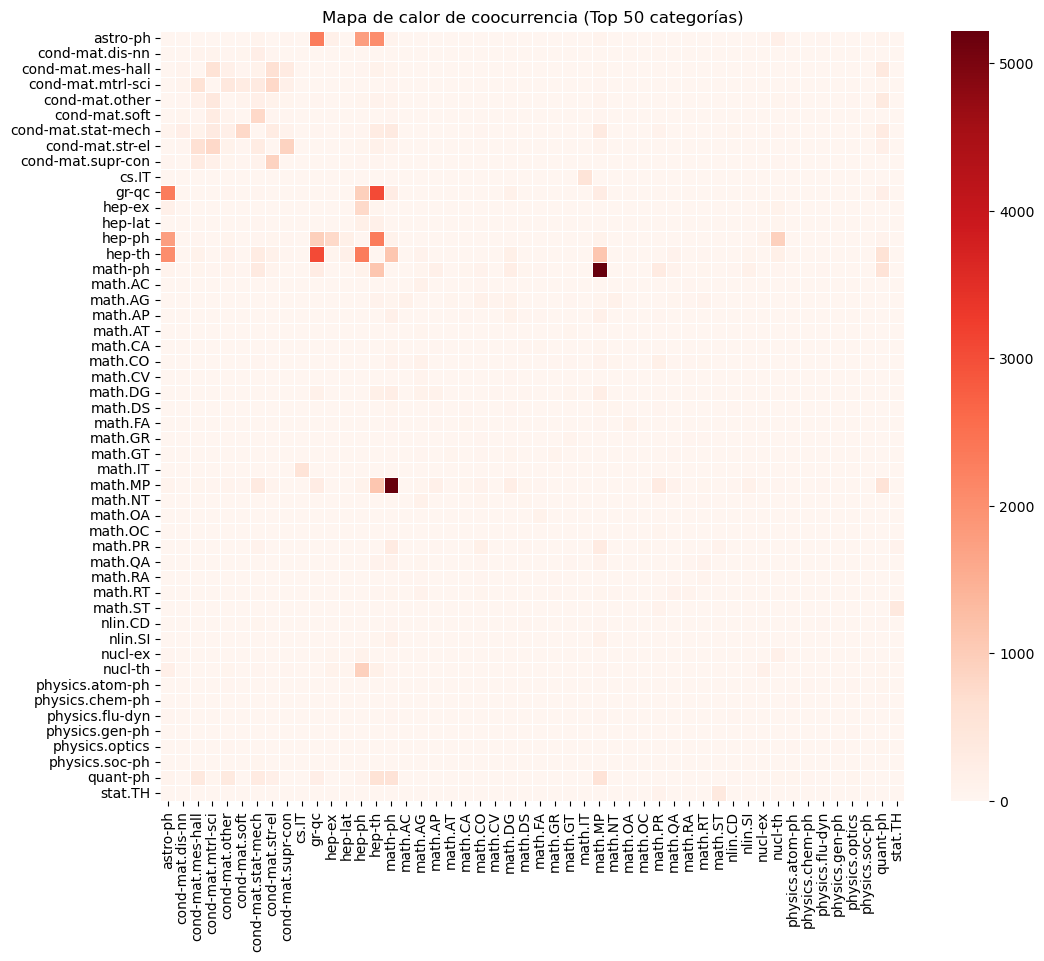

In [99]:
#Take the main (first) category for each paper
TOP_N=50

all_cats = []
for cat in df['categories']:
    all_cats.extend(cat.split())

c = Counter(all_cats)
top_cat = [cat for cat, _ in cat_freq.most_common(TOP_N)]

# FIlter to most common categories
coocurrence = Counter()
for cats in df["categories"]:
    cat_list = [c for c in cats.split() if c in top_cat]
    for c1, c2 in combinations(sorted(set(cat_list)), 2):
        cooccurrence[(c1, c2)] += 1

# Matrix
cat_list_unique = sorted(top_cat)
matrix = pd.DataFrame(0, index=cat_list_unique, columns=cat_list_unique)

# Counting
for (c1, c2), count in cooccurrence.items():
    matrix.loc[c1, c2] = count
    matrix.loc[c2, c1] = count

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap="Reds", linewidths=0.5, annot=False)
plt.title(f"Mapa de calor de coocurrencia (Top {TOP_N} categorías)")
plt.show()


### WordCloud Abstracts

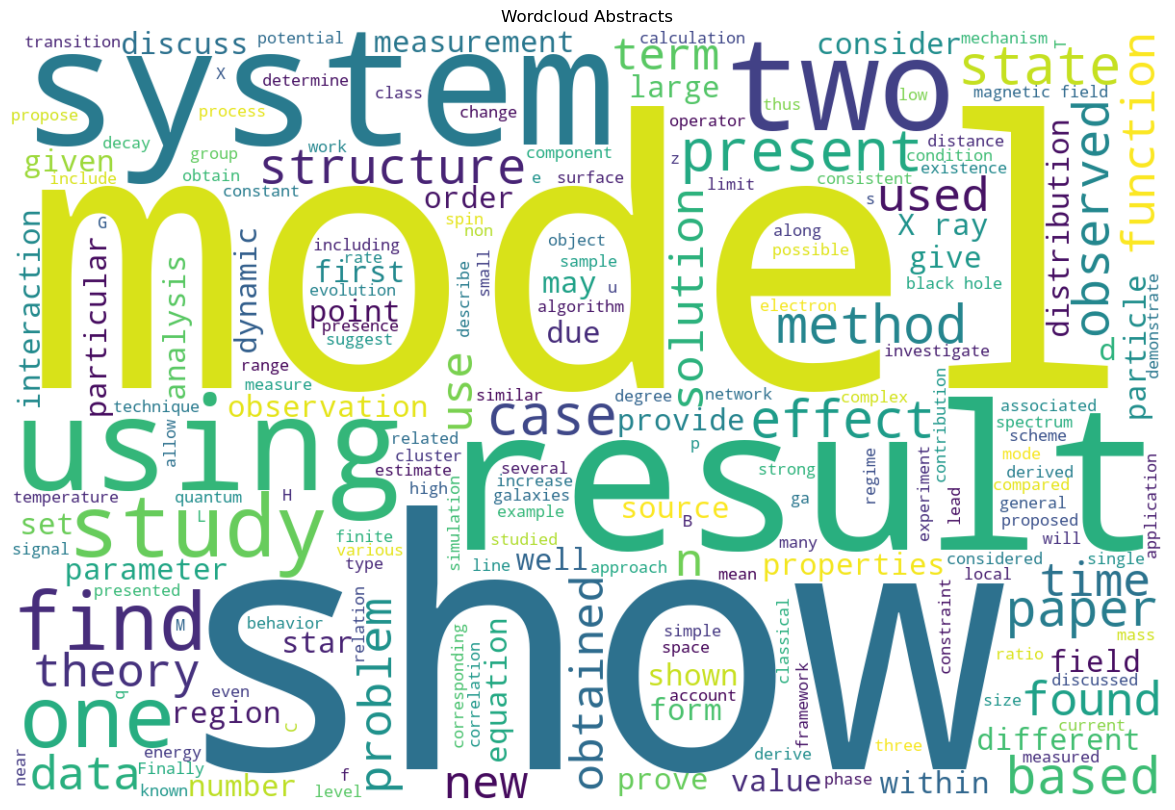

In [104]:
abstracts_all_text = " ".join(df['abstract'].tolist())

wc_abstract = WordCloud(width=1200, height=800, background_color="white",)
wc_abstract.generate(abstracts_all_text)

plt.figure(figsize=(20,10))
plt.imshow(wc_abstract, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Abstracts")
plt.show()

### WordCloud Titles

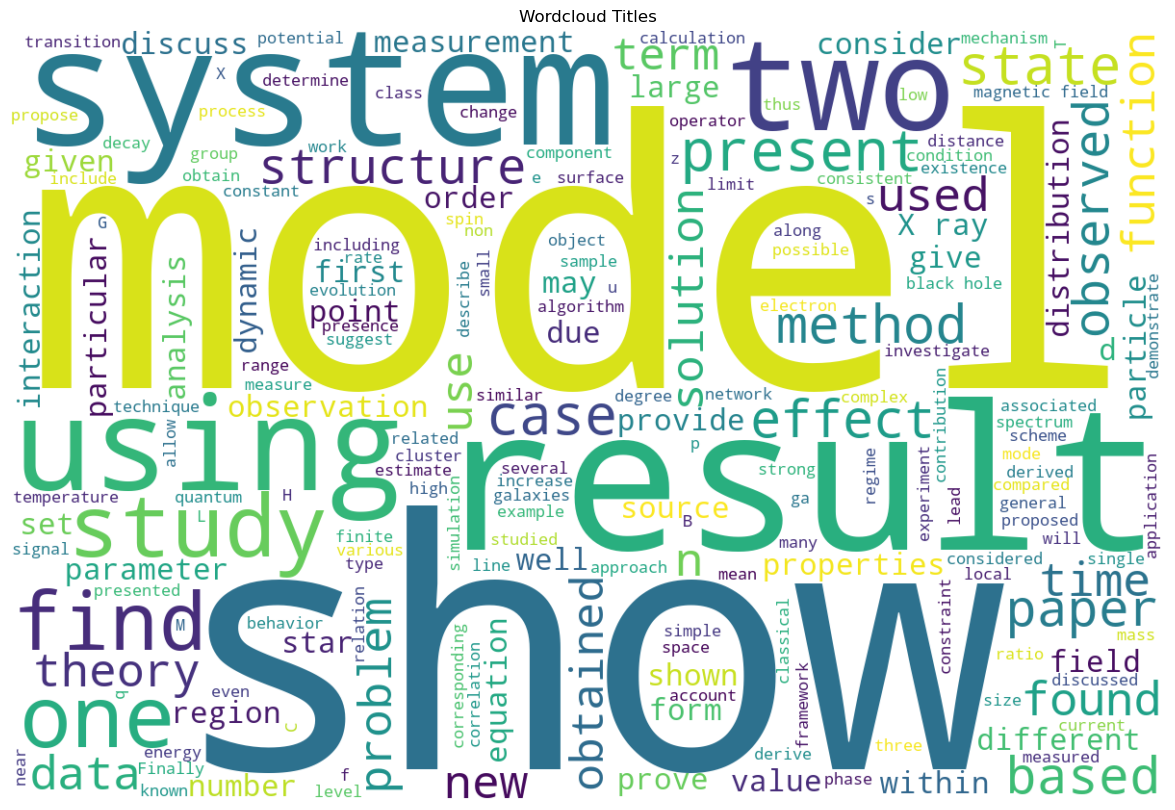

In [105]:
titles_all_text = " ".join(df['title'].tolist())

wc_titles = WordCloud(width=1200, height=800, background_color="white",)
wc_titles.generate(titles_all_text)
plt.figure(figsize=(20,10))
plt.imshow(wc_abstract, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Titles")
plt.show()